In [1]:
#for loading data
import pandas as pd
import json

#for llm
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#logging
import pickle

#similarity
from sentence_transformers import SentenceTransformer

#visualization
#plot matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [16]:
job_statements = pd.read_excel("datasets/task_statements.xlsx")
job_statements.columns = job_statements.columns.str.lower()
job_statements = job_statements.drop(labels=["incumbents responding","date","domain source"], axis=1).rename(columns={"o*net-soc code":"code", "task type":"type", "task id": "id"})
job_statements = job_statements[~job_statements["type"].str.contains("Supplemental", case=False, na=True)]

In [21]:
job_statements

,code,title,id,task,type
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core
2,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core
4,11-1011.00,Chief Executives,8834,Prepare or present reports concerning activiti...,Core
...,...,...,...,...,...
18781,53-7121.00,"Tank Car, Truck, and Ship Loaders",12793,Observe positions of cars passing loading spou...,Core
18782,53-7121.00,"Tank Car, Truck, and Ship Loaders",12795,Monitor product movement to and from storage t...,Core
18783,53-7121.00,"Tank Car, Truck, and Ship Loaders",12794,"Operate ship loading and unloading equipment, ...",Core
18784,53-7121.00,"Tank Car, Truck, and Ship Loaders",12796,Record operating data such as products and qua...,Core


In [3]:
# set up occupation data
occupations = pd.read_excel('datasets/occupation_data.xlsx').dropna()
occupations.columns = occupations.columns.str.lower()
#rename the column 
occupations = occupations.rename(columns={'o*net-soc code':'code'})   
#drop rows with "all other" in the content
occupations = occupations[~occupations['title'].str.contains("All Other")]
#change data type
occupations['code'] = occupations['code'].astype(str)
occupations['title'] = occupations['title'].astype(str)
occupations['description'] = occupations['description'].astype(str)

test_occ = occupations.sample(1, random_state=1).iloc[0].title
test_occ



'Customer Service Representatives'

In [4]:
def get_des (title):
    task_list = list(job_statements.query("title == @title")["task"])
    return task_list

In [29]:
get_des(test_occ)

['Confer with customers by telephone or in person to provide information about products or services, take or enter orders, cancel accounts, or obtain details of complaints.',
 'Keep records of customer interactions or transactions, recording details of inquiries, complaints, or comments, as well as actions taken.',
 "Check to ensure that appropriate changes were made to resolve customers' problems.",
 'Contact customers to respond to inquiries or to notify them of claim investigation results or any planned adjustments.',
 'Determine charges for services requested, collect deposits or payments, or arrange for billing.',
 'Complete contract forms, prepare change of address records, or issue service discontinuance orders, using computers.',
 'Refer unresolved customer grievances to designated departments for further investigation.']

### set up matching function

In [33]:
def match(gen, ref):
    sim_model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")

    # Compute embeddings for both lists
    embeddings_gen = sim_model.encode(gen)
    embeddings_ref = sim_model.encode(ref)

    # Compute cosine similarities
    similarities = sim_model.similarity(embeddings_gen, embeddings_ref)
    return similarities

In [41]:
#plot graph
def plot(similarities):
    x_label = [x+1 for x in range(len(similarities))]
    y_label = [chr(num + 96) for num in x_label]
    plt.figure(figsize=(12, 12))
    sns.heatmap(similarities, annot=True, fmt=".3f", cmap="crest", xticklabels=x_label, yticklabels=y_label)
    plt.title("Sentence Cosine Similarity for "+ test_occ)
    plt.xlabel("O*NET Data")
    plt.ylabel("Generated Sentence")
    plt.savefig("results/"+test_occ+".png")
    plt.show()
    return plt

### get llm

In [36]:
from pydantic import BaseModel

class job_statement(BaseModel):
  role: str
  task_statements: list[str]


#initialize model
# model= ChatOllama(model="llama3.1", temperature=1), format= 'json')
model= ChatOllama(model="llama3.1", temperature=1)

chat_history = []
answer = []
task = "generate "+str(len(get_des(test_occ)))+" task statements that you would perform at work."

prompt_template = ChatPromptTemplate([
        ("system", "your role is a {name}. Respond like a {name}."),
        ("placeholder", "{chat_history}"),
        ("human","{input}")
        ]
)
structured_llm = model.with_structured_output(schema=job_statement.model_json_schema())

prompt = prompt_template.invoke({"name": test_occ, "chat_history" : chat_history[-10:], "input": task})
response = structured_llm.invoke(prompt)
# response = model.invoke(prompt)
chat_history.append(HumanMessage(content=task))
chat_history.append(AIMessage(str(response)))
# answer.append(response["interest"])
# processed = "".join(str(answer[i])for i in range(len(answer)))
chat_history

[HumanMessage(content='generate 7 task statements that you would perform at work.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='{\'role\': \'Customer Service Representative\', \'task_statements\': \'["Answer customer inquiries","Resolve customer complaints","Provide product information","Process customer orders","Handle customer feedback","Maintain accurate records","Stay up-to-date with company policies"]\'}', additional_kwargs={}, response_metadata={})]

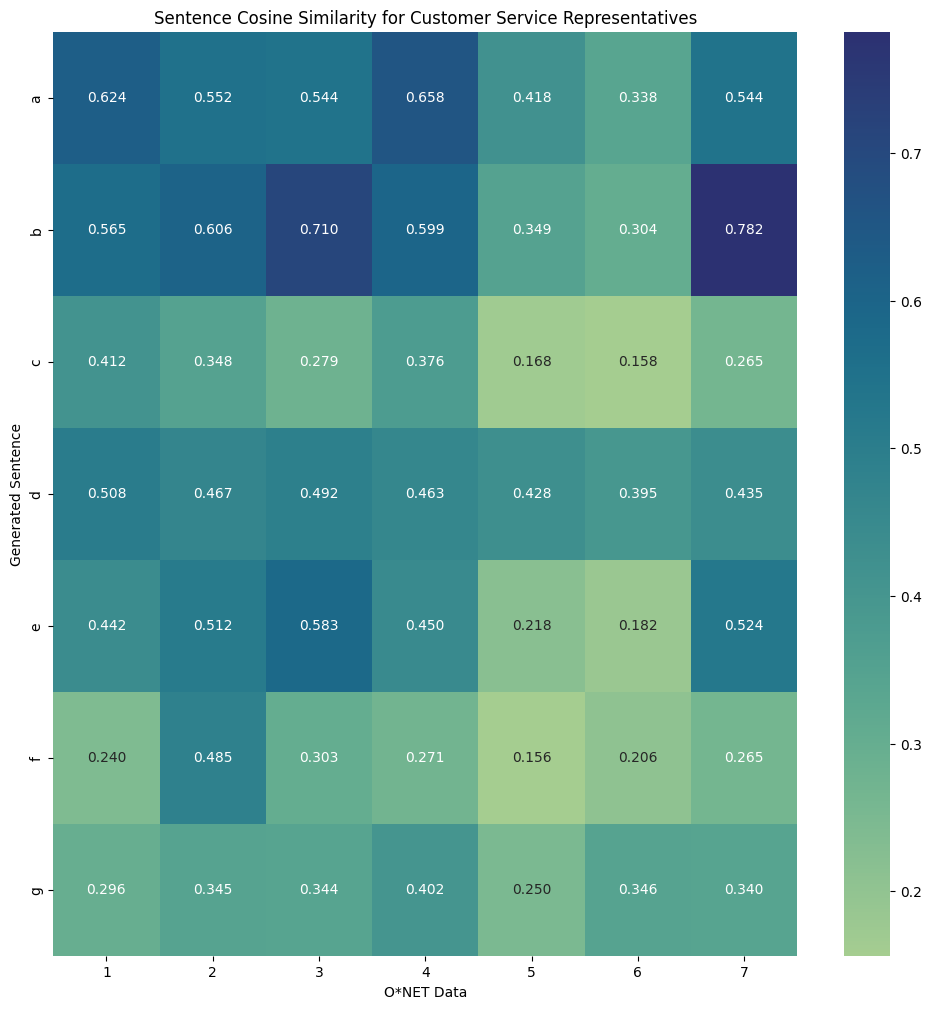

['Answer customer inquiries', 'Resolve customer complaints', 'Provide product information', 'Process customer orders', 'Handle customer feedback', 'Maintain accurate records', 'Stay up-to-date with company policies']


In [42]:
if type(response["task_statements"]) == str:
    js = json.loads(response["task_statements"])
    plot(match(js, get_des(test_occ)))
    print(js)
else:
    plot(match(response["task_statements"], get_des(test_occ)))
    print(response["task_statements"])